# 워드 클라우드 만들기

### 데이터 불러오고 전처리

In [1]:
import pandas as pd
df = pd.read_csv("tmp.csv")

In [11]:
from konlpy.tag import Okt
okt = Okt()

In [336]:
def clean_text(text):
    text = okt.pos(text, norm = True, stem = True)
    tmp = []
    conti = False
    for i in text:
#         print(i)
        if len(i[0])<2:
            continue
        if conti and i[1] == "Verb":
            tmp.append(conti_word + i[0])
            conti = False
            continue
            
        if i[1] == "VerbPrefix":
            conti = True
            conti_word = i[0]
            continue
            
        if i[1] == "Suffix" and prev[1] == "Noun":
            del tmp[-1]
            tmp.append(prev[0] + i[0])
            continue
           

                
        elif i[0] == "하다" or i[0] == "있다" or i[0] == "없다" or i[0] == "되다":
            try:
                if prev[1] == "Adverb":
                    tmp.append(prev[0] + i[0])
                    continue
            except:
                continue
            try:
                if prev[1] == "Noun":   
                    try:
                        del tmp[-1]
                        tmp.append(prev[0] + i[0])
                        continue
                    except:
                        tmp.append(i[0])
            except:
                continue
            

        if  i[1] == "Noun" or i[1] == "Verb" or i[1] == "Adjective" or i[1] == "Suffix" or i[1] =="KoreanParticle":
            tmp.append(i[0])
            prev = (i[0], i[1])
        elif i[1] == "Adverb":
            prev = (i[0], i[1])
    
    return " ".join(tmp)

In [7]:
df["전처리"] = df["강의평"].map(clean_text)

In [190]:
df.head()

,Unnamed: 0,강의평,별점,긍정부정,전처리
0,0,교수님이 강의력이 좀 떨어지긴 하지만 학생들을 많이 생각하시는 분입니다. 시험은 ...,5,pos,교수 강의 떨어지다 학생 생각하다 이다 시험 실습 푸다 문제 안보 혼자 작성하다 정...
1,1,강의력은 별로신데 그래도 나온 점수에 비해 학점을 잘나왔어요. 비율은 꽉꽉 채워주시...,2,neg,강의 별로 신다 나오다 점수 비다 학점 잘나오다 비율 채우다
2,2,솔직히 강의 떄는 들을거 없음 걍 자면 됨 계속 고통받았다 사실상 소질있는 애들과 ...,3,mid,솔직하다 강의 들다 없다 자다 되다 계속 고통 받다 사실 소질없다 차이 가장 크다 ...
3,3,이 선생님은 수업 때 아예 자는것이 훨씬 효율적이라 느꼈습니다. 저는 a+을 받았지...,1,neg,선생님 수업 아예 자다 효율 느끼다 받다 이다 오직 재능 달성하다 강의 설명하다 딱...
4,4,1년동안 수업들으면서 학생들을 많이 생각하신다는 느낌을 받았습니다. 다만 강의력이 ...,4,pos,수업 들다 학생 생각하다 느낌 받다 다만 강의 떨어지다 시험 준비 실습 시간되다 시...


In [314]:
five =df[df["긍정부정"] == "pos"]

### 워드 클라우드 제작
단순히 단어의 빈도가 높은 것에 대해서 워드 클라우드로 만들어줌

In [315]:
tmp = []
stop_word = ["하다", "교수님", "수업", ]
for i in list(five.전처리):
    for j in i.split():
        if j not in stop_word:
            tmp.append(j)

In [316]:
def __array__(self):
    """Convert to numpy array.
    Returns 
    -------
    image : nd-array size (width, height, 3)
        Word cloud image as numpy matrix.
    """
    return self.to_array()

def to_array(self):
    return np.array(self.to_image())

#윈도우용
#font_path = 'C:/Windows/Fonts/malgun.ttf'

font_path="/Library/Fonts/AppleGothic.ttf"

In [317]:
from collections import Counter
from wordcloud import WordCloud
%matplotlib inline
import matplotlib.pyplot as plt

In [318]:
wordcloud=WordCloud(font_path=font_path, width=800, height=800, 
                    background_color="white", colormap="Set2")

In [319]:
wordcloud=wordcloud.generate_from_frequencies(Counter(tmp))
array=wordcloud.to_array()

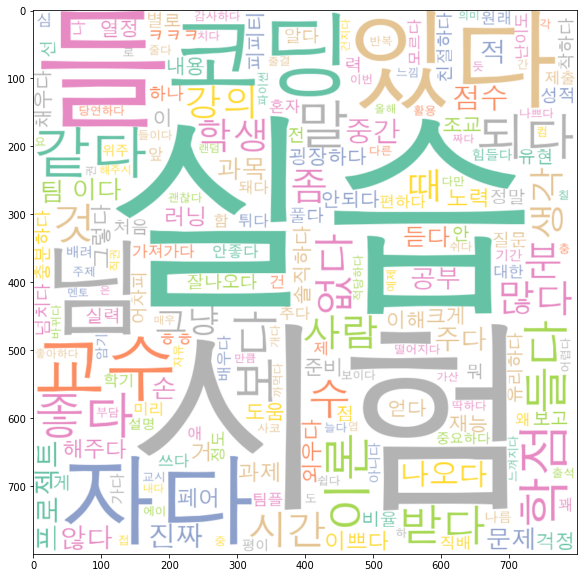

In [320]:
fig=plt.figure(figsize=(10,10))
plt.imshow(array, interpolation="bilinear")
plt.show()

# topic modeling 토픽 모델링

In [208]:
neg_df =df[df["긍정부정"] == "pos"]
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

x = vectorizer.fit_transform(neg_df["전처리"])
x.shape 

(50, 483)

In [209]:
from sklearn.decomposition import TruncatedSVD
svd_model = TruncatedSVD(n_components=3, algorithm="randomized", 
                         n_iter= 100, random_state= 122)
svd_model.fit(x)
len(svd_model.components_)

3

In [210]:
terms = vectorizer.get_feature_names() # 단어 집합. 1,000개의 단어가 저장됨.

def get_topics(components, feature_names, n = 5):
    for idx, topic in enumerate(components):
        print("Topic %d:" %(idx+1), 
              [(feature_names[i], topic[i].round(5)) 
               for i in topic.argsort()[:-n-1:-1]])
get_topics(svd_model.components_, terms)

Topic 1: [('수업', 0.41745), ('실습', 0.37711), ('자다', 0.26577), ('시험', 0.22941), ('같다', 0.20176)]
Topic 2: [('같다', 0.26109), ('교수', 0.25546), ('열심히하다', 0.23431), ('좋다', 0.21398), ('학생', 0.19374)]
Topic 3: [('자다', 0.19246), ('실습', 0.16921), ('시험', 0.16296), ('프로젝트', 0.16071), ('보다', 0.15678)]
